In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np
from functools import partial
from scipy.optimize import minimize

import torch
import torch.optim as optim
from torch.optim import Adam

from nflows.flows import MaskedAutoregressiveFlow

# Plot functions

In [2]:
def plot_x_point(x, x_origin, model):
    model.eval()
    fig, ax = plt.subplots()
    x_res = x.detach().numpy().squeeze()
    x_origin = x_origin.numpy().squeeze()
    dist = np.linalg.norm(x_res - x_origin)

    with torch.no_grad():
        samples_zero, log_probs = model.sample_and_log_prob(512, context=torch.Tensor([[0]]))
        samples_one, log_probs = model.sample_and_log_prob(512, context=torch.ones(1, 1))


    ax.set_title(f"{x.detach().numpy()}, dist: {dist}")
    ax.scatter(samples_zero.squeeze()[:, 0], samples_zero.squeeze()[:, 1], c="g")
    ax.scatter(samples_one.squeeze()[:, 0], samples_one.squeeze()[:, 1], c="b")
    ax.arrow(x_origin[0], x_origin[1], x_res[0]-x_origin[0], x_res[1]-x_origin[1], width=0.025, length_includes_head=True, color="C3")
    ax.scatter(x_origin[0], x_origin[1], c="r")

In [15]:
def plot_distributions(x, x_orig, model, optim_function, alpha):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12,5)

    xline = torch.linspace(-1.5, 2.5, 200)
    yline = torch.linspace(-.75, 1.25, 200)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    x_res = x.detach().numpy().squeeze()
    
    with torch.no_grad():
        zgrid0 = - model.log_prob(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200) \
                - model.log_prob(xyinput, torch.zeros(40000, 1)).exp().reshape(200, 200)

        zgrid1 = optim_function(xyinput, x_orig, model, alpha).reshape(200, 200)

        # dist = np.linalg.norm(xyinput-x_orig.repeat(40000, 1), axis=1).reshape(200, 200)
        # p_orig = flow.log_prob(x_orig, context=torch.Tensor([[0]])).exp().item()
        # p_hat = flow.log_prob(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200)
        # theta = np.abs(p_orig - p_hat)
        # zgrid1 = theta + i*dist

    ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy(), levels=20)
    ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1, levels=20)
    ax[0].scatter(x_orig[0,0], x_orig[0,1], c="r")
    ax[1].scatter(x_orig[0,0], x_orig[0,1], c="r")

    ax[0].arrow(x_orig[0, 0], x_orig[0, 1], x_res[0]-x_orig[0, 0], x_res[1]-x_orig[0, 1], width=0.025, length_includes_head=True, color="C3")
    ax[1].arrow(x_orig[0, 0], x_orig[0, 1], x_res[0]-x_orig[0, 0], x_res[1]-x_orig[0, 1], width=0.025, length_includes_head=True, color="C3")
    log_p = model.log_prob(x, context=torch.Tensor([[1]])).exp().item()
    log_p_origin = model.log_prob(x_orig, context=torch.Tensor([[0]])).exp().item()
    ax[0].set_title(f"log_p_orig: {log_p_origin:.2e}")
    ax[1].set_title(f"Distance: {np.linalg.norm(x_orig - x_res):0.2f}, log_p: {log_p:.2e}")
    plt.show()

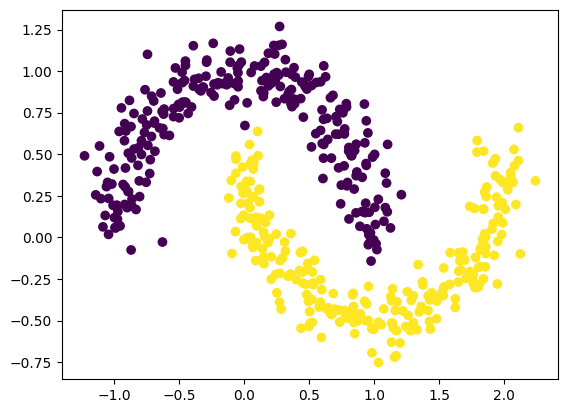

In [4]:
x, y = datasets.make_moons(512, noise=0.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [22]:
flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
optimizer = optim.Adam(flow.parameters())

In [23]:
num_iter = 3000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    if (i + 1) % 500 == 0:
        print(loss.item())

0.8317408561706543
0.5338953733444214
0.41490858793258667
0.3774751126766205
0.2947450876235962
0.5472662448883057


# Approach 1

$$ argmin \quad d(x, x’) - log p(x’|y’)$$
$$ log p(x’|y’) = log p(y’|x’)*p(x') $$

In [26]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)

def optim_function(x, x_origin, model, alpha=1.0):
    model.eval()
    # y_orig = torch.zeros(x.shape[0]).reshape(-1, 1)
    y_hat = torch.ones(x.shape[0]).reshape(-1, 1)
    p_hat = model.log_prob(x, context=y_hat) #.exp()
    dist = torch.linalg.norm(x_origin-x, axis=1)
    return dist - p_hat

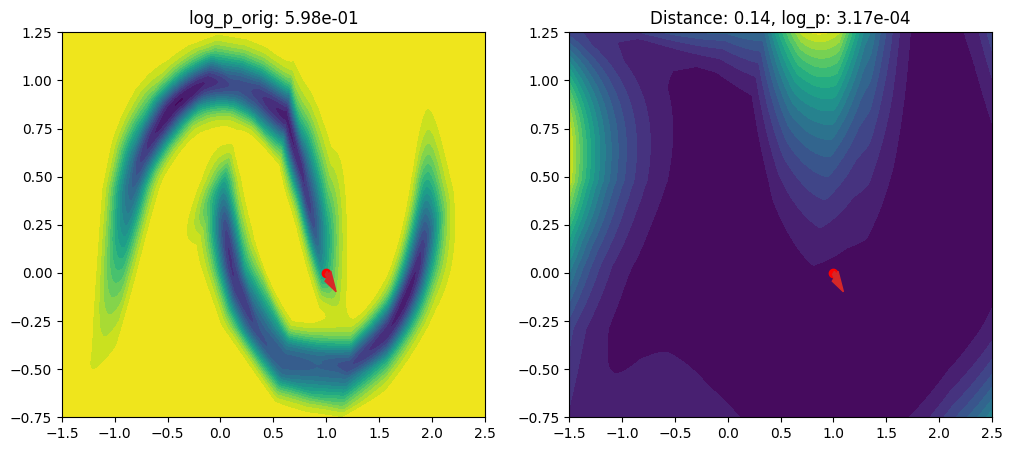

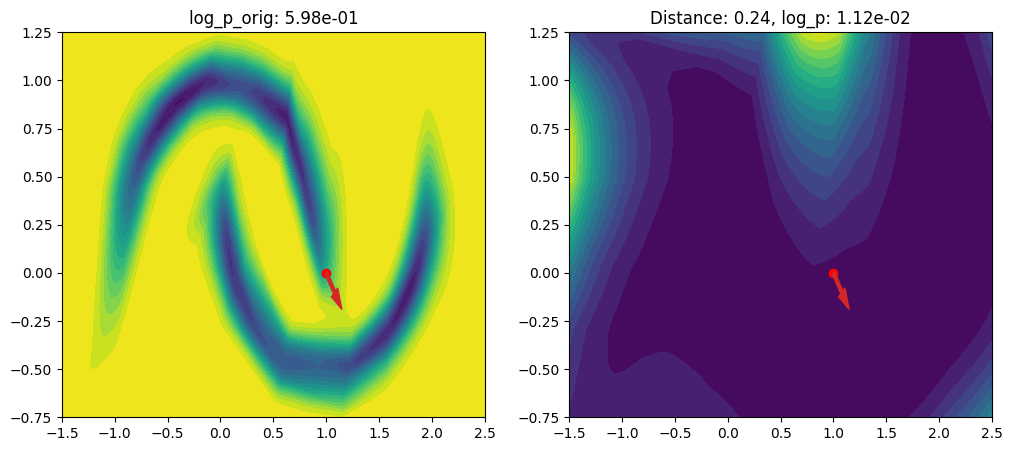

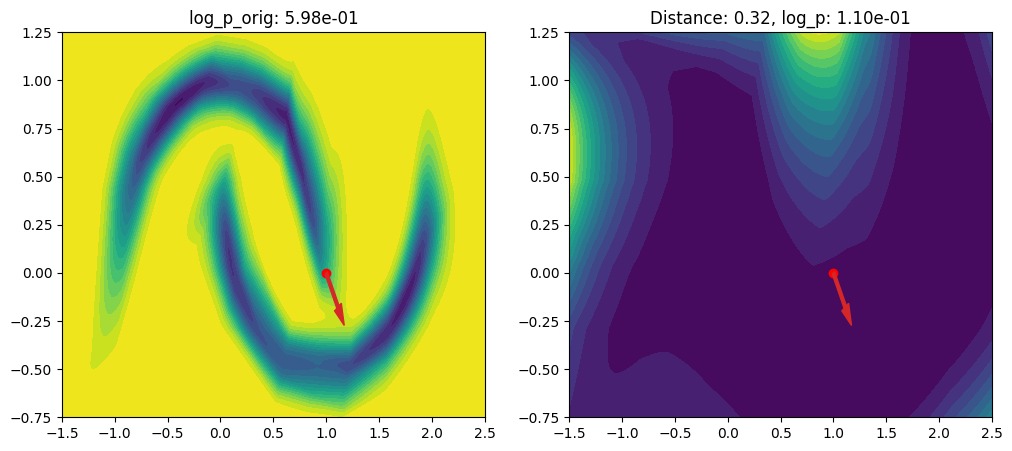

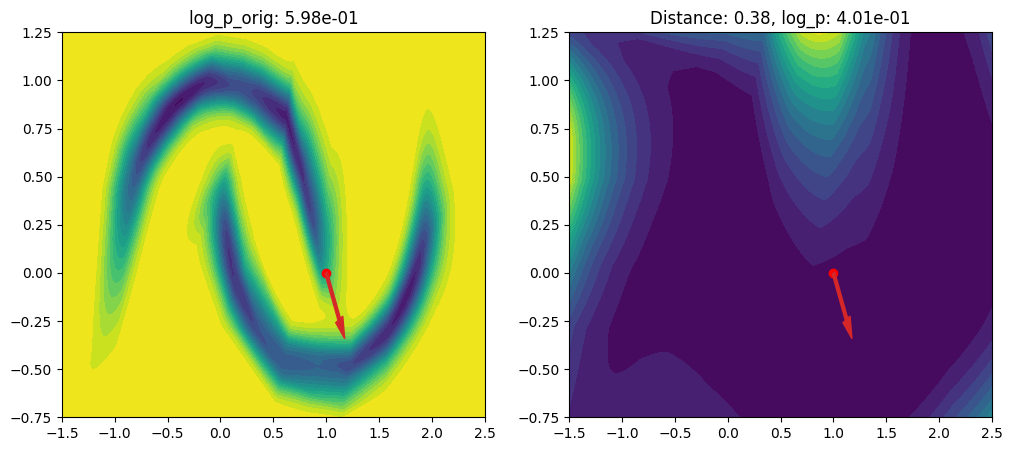

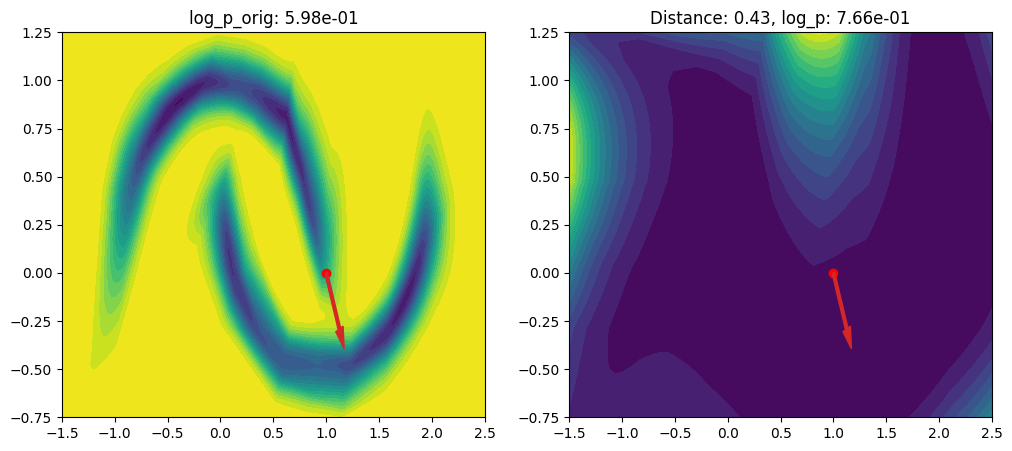

In [27]:
optimizer = Adam([x], lr=0.01)

num_iterations = 50
for i in range(num_iterations):
    flow.train()
    y = optim_function(x, x_origin, flow, alpha=100)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        plot_distributions(x, x_origin, flow, optim_function, alpha=100)

# Approach 2

$$agmin\quad d(x, x’) - \lambda (log p(x’|y’) - log(p(x’|y) + p(x’|y')))$$

In [28]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)

def optim_function(x, x_origin, model, alpha=1.0):
    model.eval()

    y_orig = torch.zeros(x.shape[0]).reshape(-1, 1)
    y_hat = torch.ones(x.shape[0]).reshape(-1, 1)

    dist = torch.linalg.norm(x_origin-x, axis=1)
    
    p_orig = model.log_prob(x, context=y_orig)
    p_hat = model.log_prob(x, context=y_hat)
    
    return dist - alpha * (p_hat - torch.logsumexp(torch.concat([p_orig, p_hat]), dim=0))

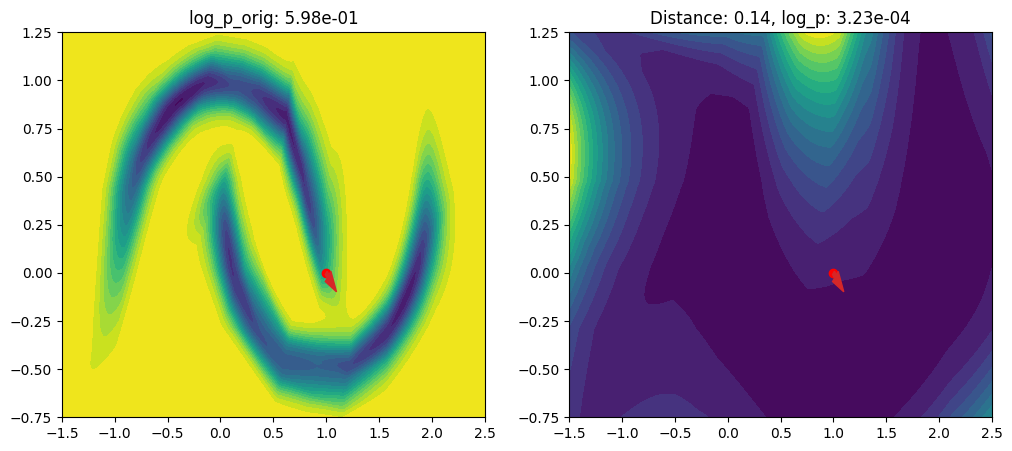

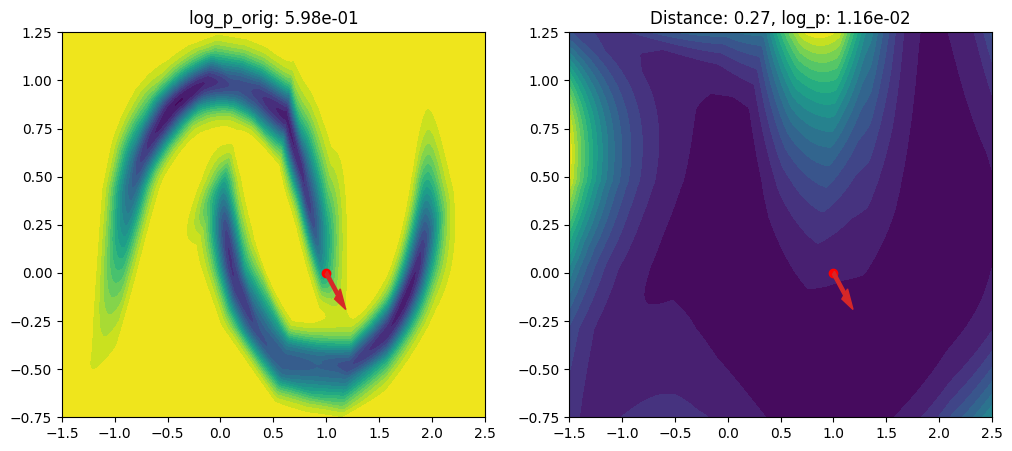

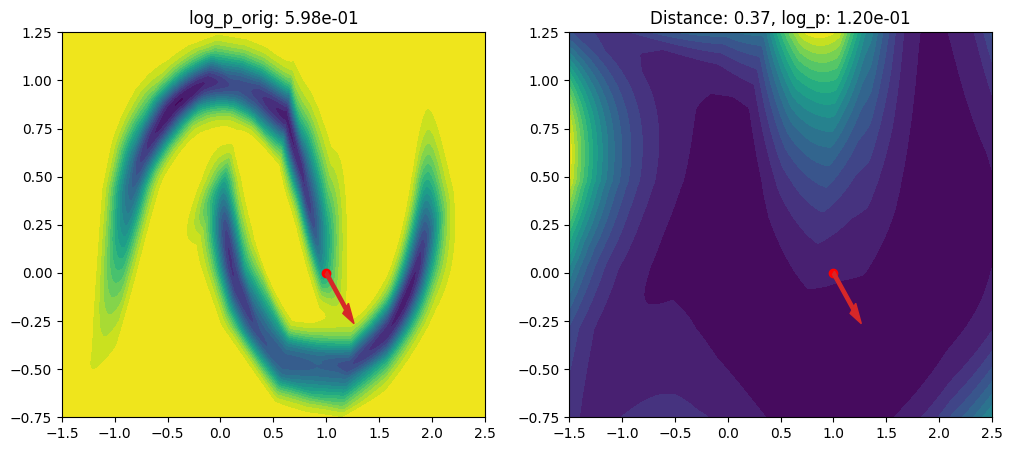

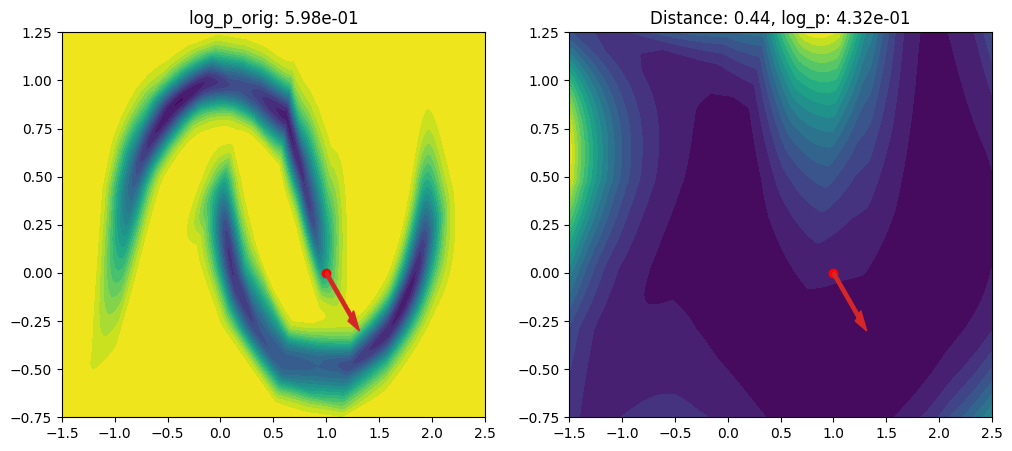

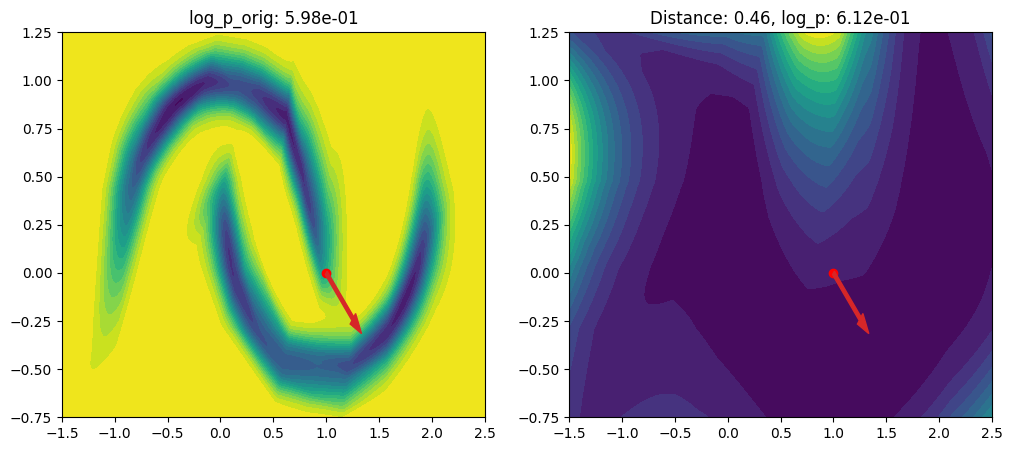

In [29]:
optimizer = Adam([x], lr=0.01)
alpha = 1

num_iterations = 50
for i in range(num_iterations):
    flow.train()
    y = optim_function(x, x_origin, flow, alpha=alpha)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        # plot_x_point(x, x_origin, flow)
        plot_distributions(x, x_origin, flow, optim_function, alpha=alpha)

# Approach 3

$$ \beta = 0.01 $$
$$\theta = \beta + p(x'|y) - p(x'|y') $$
$$agmin\quad d(x, x’) + \alpha*max(\theta, 0)$$

In [73]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)

def optim_function(x, x_origin, model, alpha=1.0, beta=0.01):
    model.eval()
    dist = torch.linalg.norm(x_origin-x, axis=1)

    y_orig = torch.zeros(x.shape[0]).reshape(-1, 1)
    y_hat = torch.ones(x.shape[0]).reshape(-1, 1)

    p_orig = model.log_prob(x, context=y_orig).exp()
    p_hat = model.log_prob(x, context=y_hat).exp()
    theta = (p_orig - p_hat + beta)
    return alpha * theta.clip(max=0) + dist

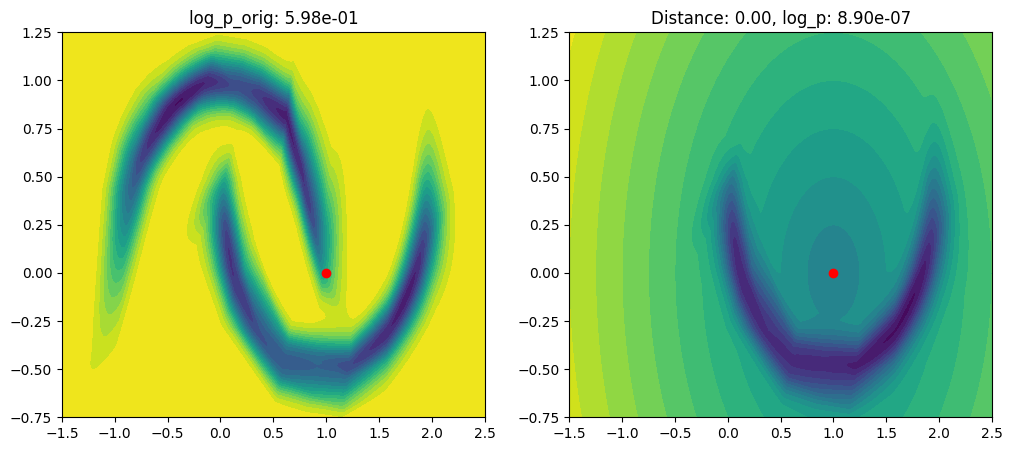

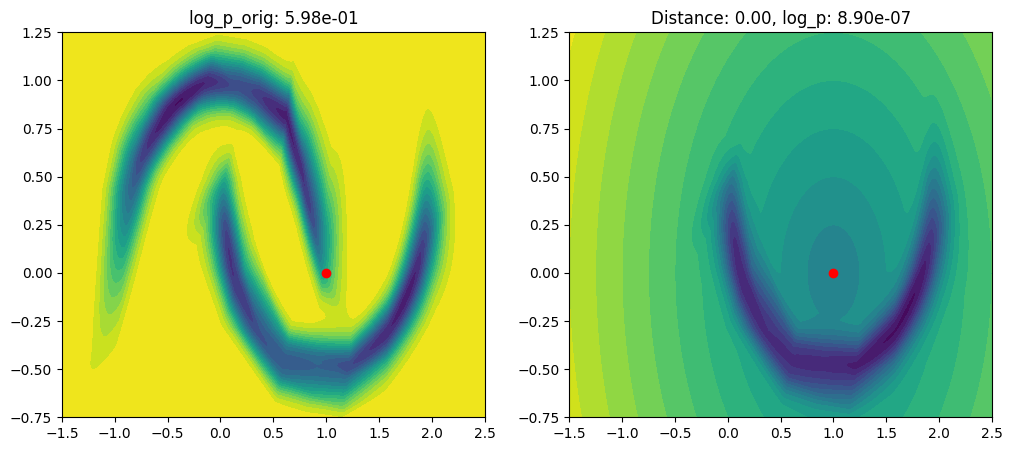

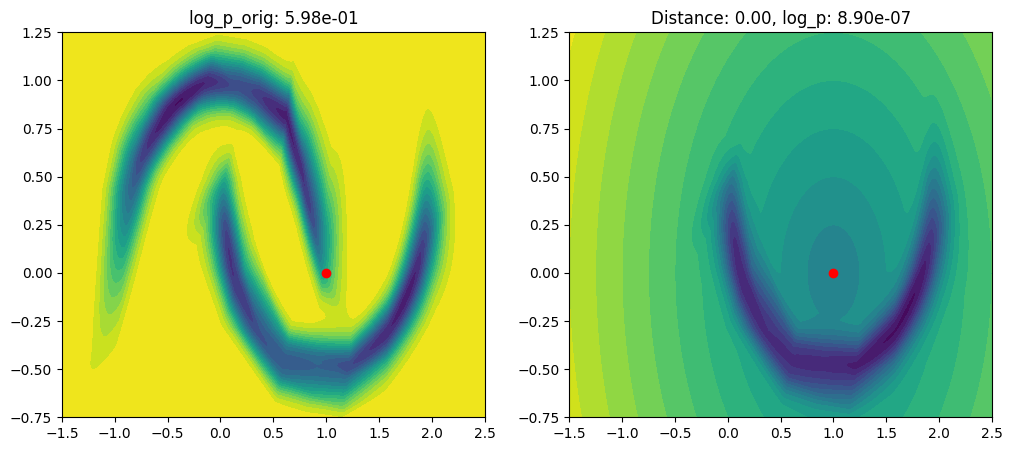

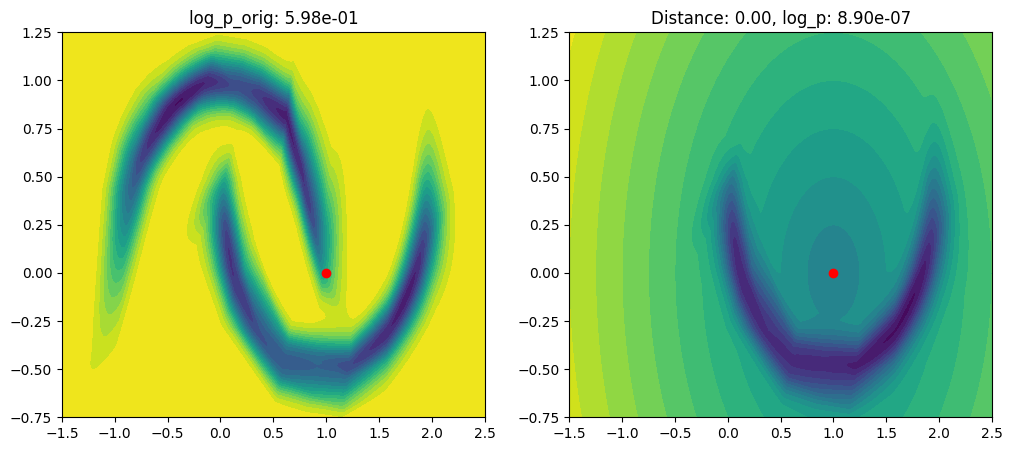

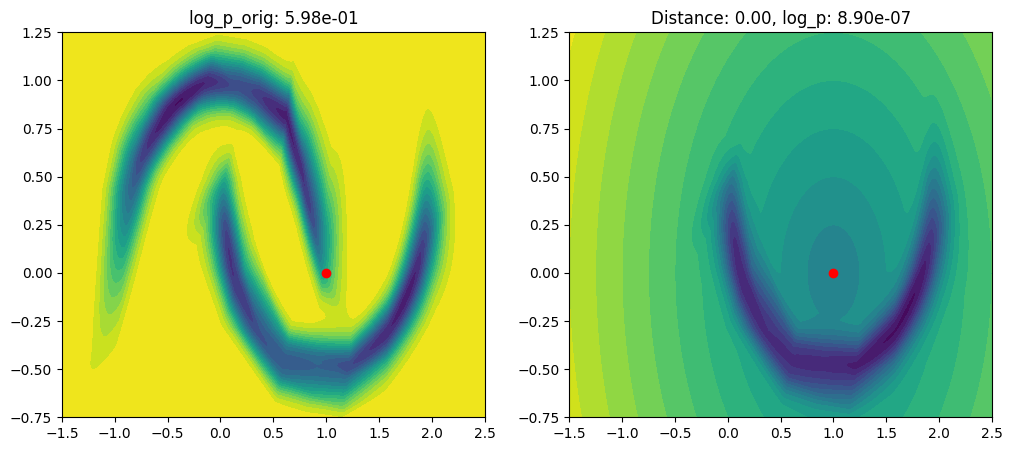

In [74]:
optimizer = Adam([x], lr=0.1)
alpha = 2

num_iterations = 50
for i in range(num_iterations):
    y = optim_function(x, x_origin, flow, alpha=alpha)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        plot_distributions(x, x_origin, flow, optim_function, alpha=alpha)

# Approach 4
$$ \alpha = 0.001 $$
$$agmin\quad \alpha * d(x, x’) + |p(x'|y') - p(x|y)|$$

In [77]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)

def optim_function(x, x_origin, model, alpha=1.0):
    model.eval()
    y_orig = torch.zeros(x_origin.shape[0]).reshape(-1, 1)
    y_hat = torch.ones(x.shape[0]).reshape(-1, 1)
    p_orig = model.log_prob(x_origin, context=y_orig).exp()
    p_hat = model.log_prob(x, context=y_hat).exp()
    theta = torch.abs(p_orig - p_hat)
    dist = torch.linalg.norm(x_origin-x, axis=1)
    return alpha * dist + theta

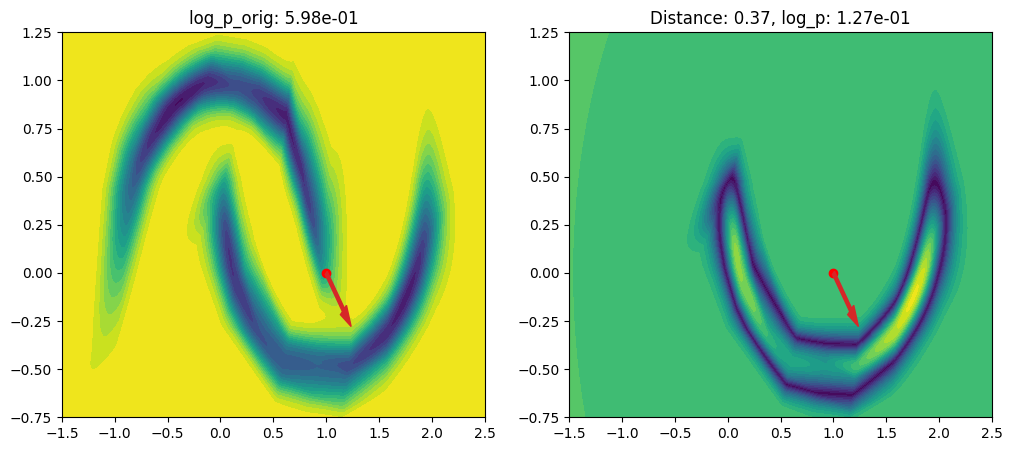

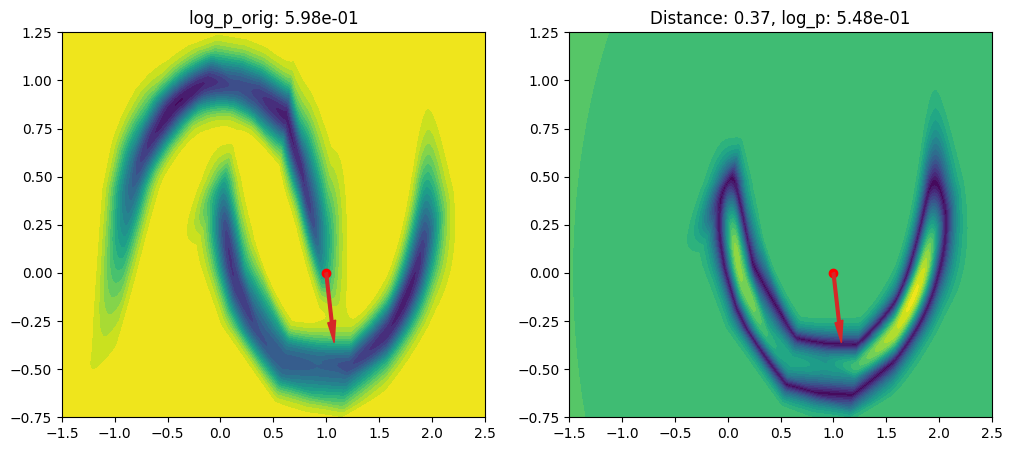

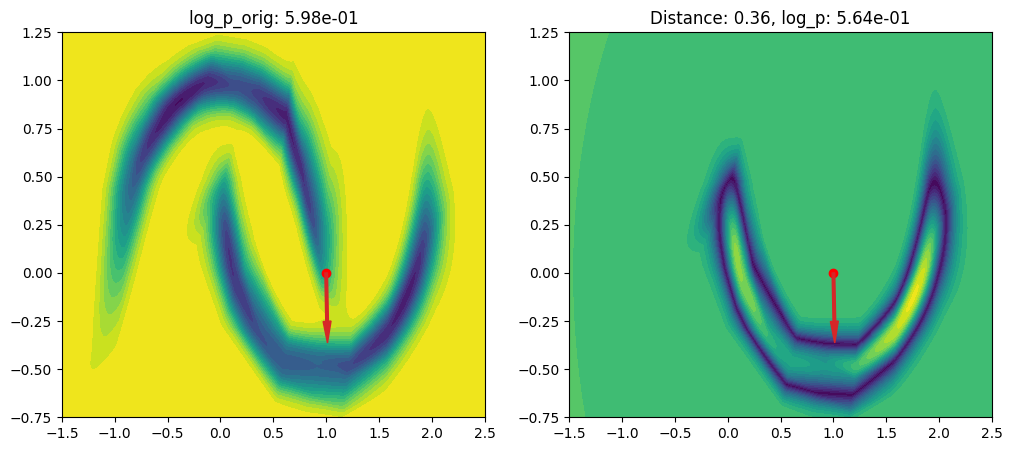

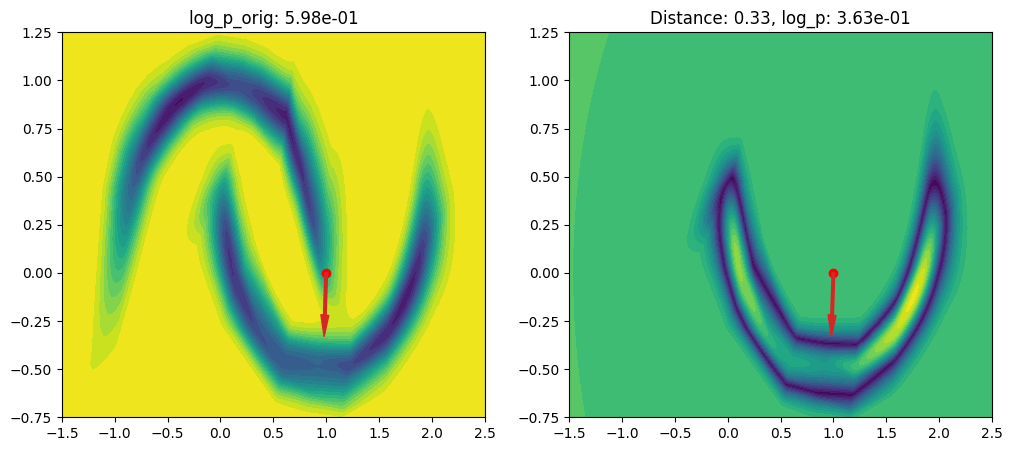

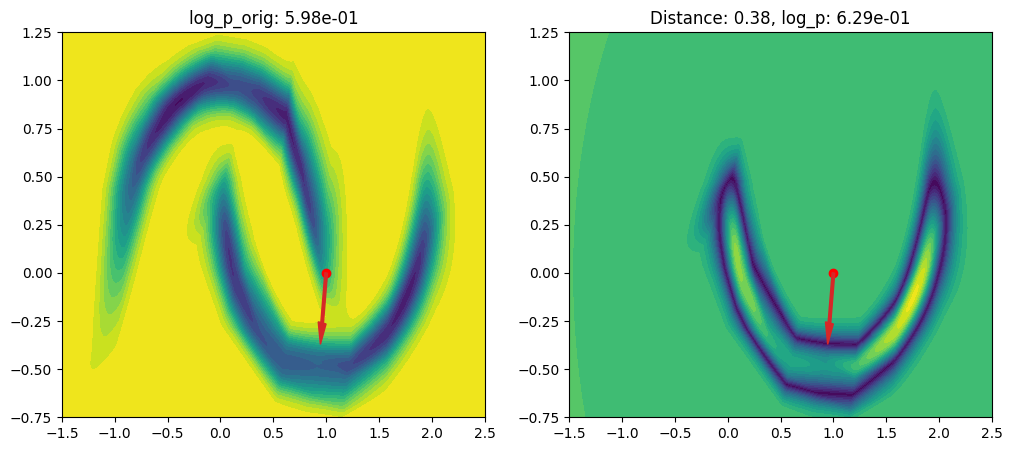

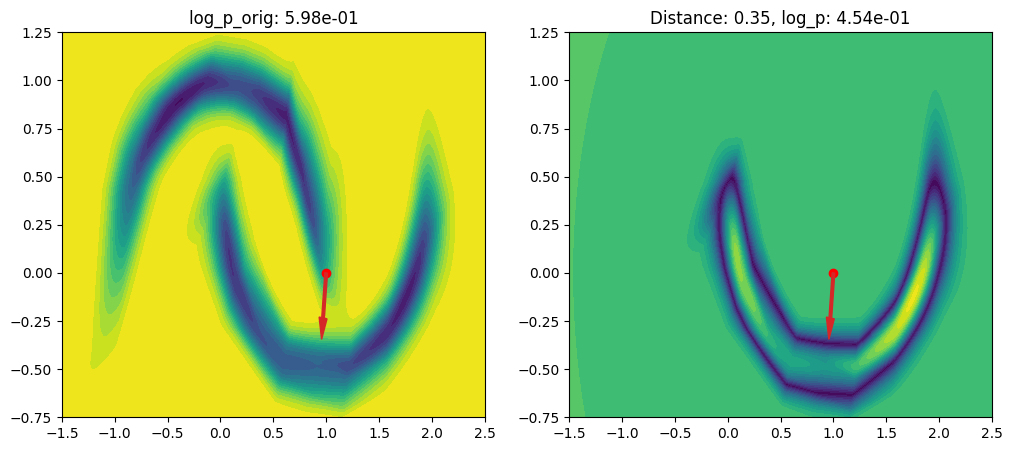

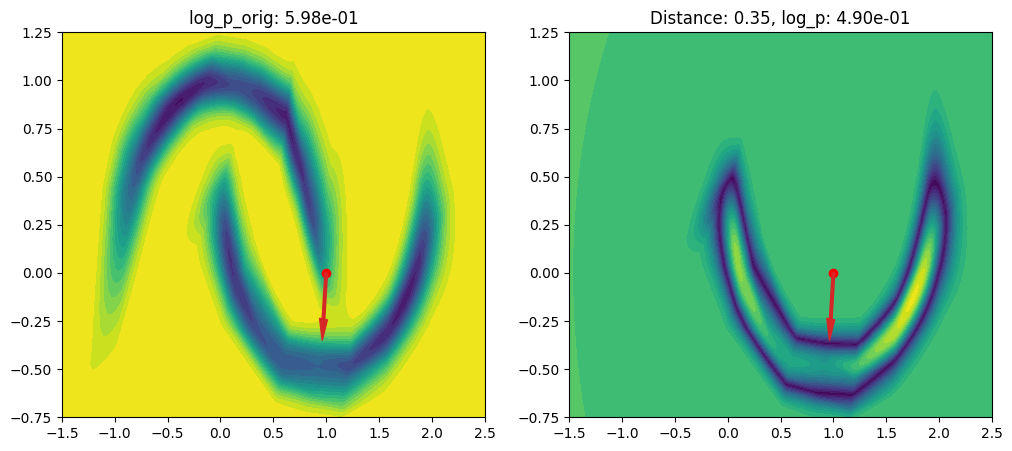

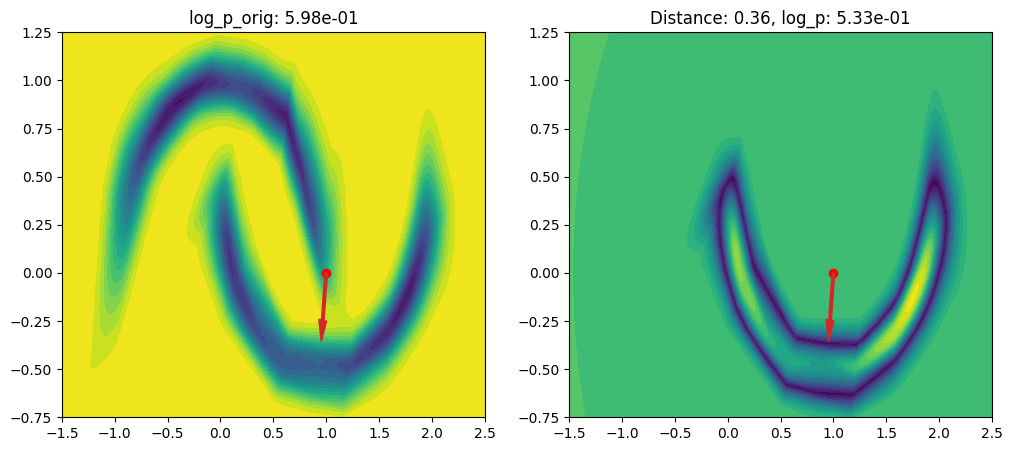

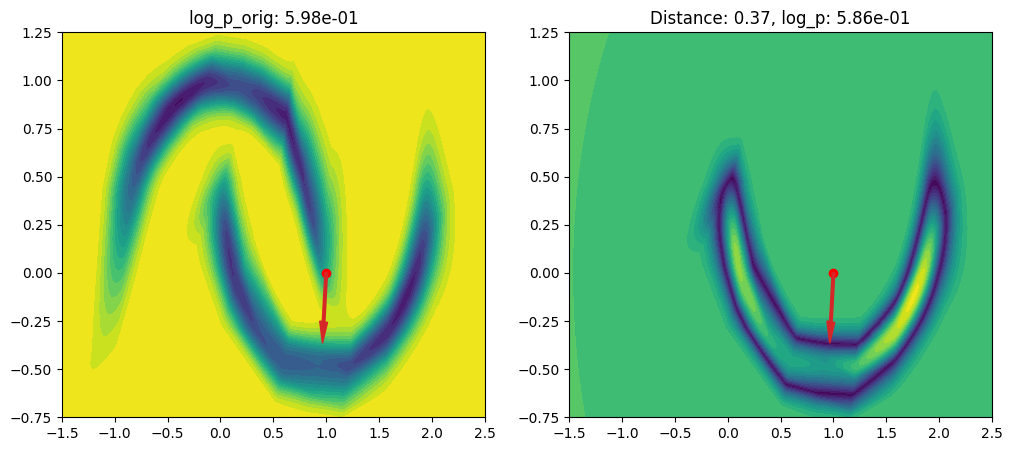

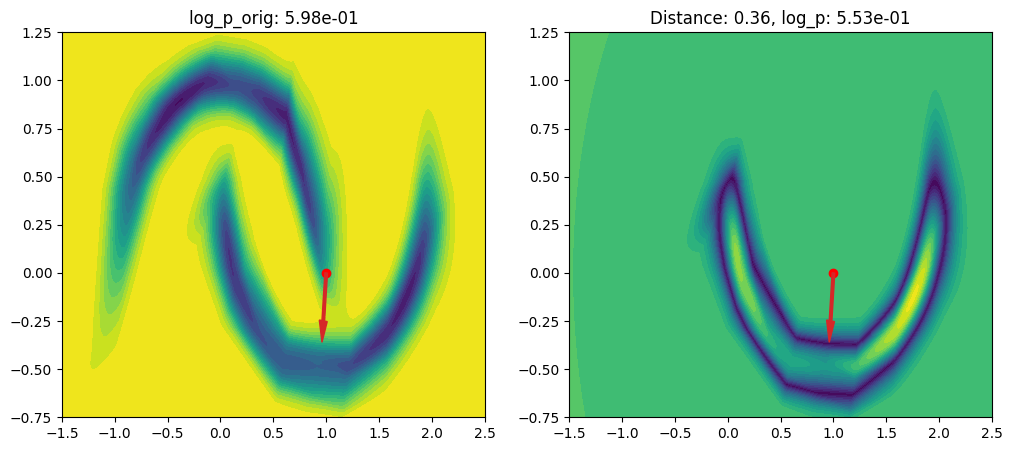

In [78]:
optimizer = Adam([x], lr=0.1)
alpha = 0.001

num_iterations = 100
for i in range(num_iterations):
    y = optim_function(x, x_origin, flow, alpha=alpha)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        plot_distributions(x, x_origin, flow, optim_function, alpha=alpha)